In [22]:
from torchvision.models import resnet18
from torchcam.methods import CAM, SmoothGradCAMpp
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [23]:
image_path = 'dataset/validation_set/img006_surprise.jpg'
image = Image.open(image_path)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(image)

# Add a batch dimension (unsqueeze the tensor)
input_tensor = input_tensor.unsqueeze(0) # The shape becomes [1, 3, 64, 64]


In [24]:
model = resnet18(pretrained=True).eval()
cam = CAM(model, 'layer4', 'fc')
with torch.no_grad(): out = model(input_tensor)
cam(class_idx=100)

/Users/wery/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/wery/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[tensor([[[0.5491, 1.0000],
          [0.0000, 0.1968]]])]

In [25]:
_, predicted_classes = torch.max(out.data, 1)
predicted_class = predicted_classes.item()
cam_image = cam(class_idx=predicted_class)
cam_tensor = cam_image[0]
cam_image_np = cam_tensor.squeeze().cpu().numpy()

cam_image_np = cam_image_np - np.min(cam_image_np)
cam_image_np = cam_image_np / np.max(cam_image_np)

/var/folders/3p/bdr8j4td0z9bjg8_ngvzj9600000gn/T/ipykernel_65999/4020557223.py:2: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  cam_image_resized = Image.fromarray(cam_image_resized).resize(image.size, Image.BILINEAR)


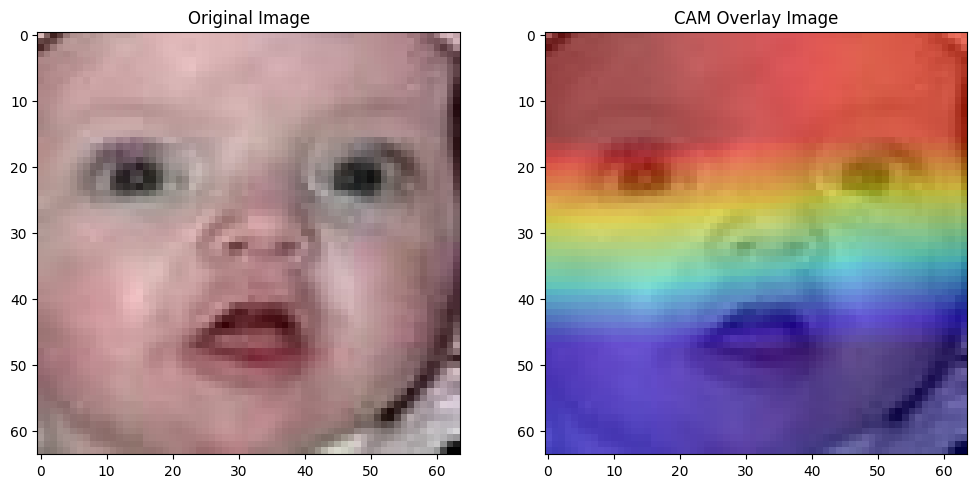

In [26]:
cam_image_resized = np.uint8(255 * cam_image_np) 
cam_image_resized = Image.fromarray(cam_image_resized).resize(image.size, Image.BILINEAR)

colormap = plt.get_cmap('jet')  
cam_image_colored = colormap(cam_image_resized)  
cam_image_colored = np.delete(cam_image_colored, 3, 2)  

overlay_image = Image.fromarray((cam_image_colored * 255).astype(np.uint8))
blended_image = Image.blend(image.convert("RGBA"), overlay_image.convert("RGBA"), alpha=0.5)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image) 
axs[0].set_title('Original Image')

axs[1].imshow(blended_image)  
axs[1].set_title('CAM Overlay Image')

plt.show()
